In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA 
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *
from util.Bollinger_bands import *


In [3]:
XAUUSD = {}
XAUUSD['D1'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['D1'] + '.csv', index_col='Time', parse_dates=True)
XAUUSD['H4'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv',index_col='Time',parse_dates=True)
XAUUSD['H1'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H1'] + '.csv', index_col='Time',parse_dates=True)
XAUUSD['M30'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['M30'] + '.csv', index_col='Time',parse_dates=True)
XAUUSD['M15'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['M15'] + '.csv', index_col='Time', parse_dates=True)
XAUUSD['M5'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['M5'] + '.csv', index_col='Time', parse_dates=True)
XAUUSD['M1'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['M1'] + '.csv', index_col='Time', parse_dates=True)

In [8]:
start_date = '2007-01-01'
end_date = '2008-01-01'

In [9]:
for i in TIMEFRAME :
    XAUUSD[i].index.name = None
    XAUUSD[i] = XAUUSD[i].loc[start_date:end_date]

In [13]:
XAUUSD['M1']

,Open,High,Low,Close,Volume
Time,,,,,
2022-08-16 23:13:00,1775.538,1775.715,1775.418,1775.715,1
2022-08-16 23:14:00,1775.715,1775.778,1775.628,1775.778,1
2022-08-16 23:15:00,1775.688,1775.688,1775.628,1775.638,1
2022-08-16 23:16:00,1775.628,1775.668,1775.598,1775.668,1
2022-08-16 23:17:00,1775.648,1775.668,1775.638,1775.668,1
...,...,...,...,...,...
2023-03-10 17:55:00,1864.635,1864.945,1864.358,1864.628,1
2023-03-10 17:56:00,1864.635,1864.985,1864.534,1864.985,1
2023-03-10 17:57:00,1865.005,1865.005,1864.415,1864.418,1


In [5]:
class Bolinger_bands(Strategy) :
    ATR_SL = 0.5
    def init(self):
        self.data.df['ATR'] = ATR(self.data.df, 20)['ATR']
        self.data.df['sma_fast'] = SMA(self.data.df,50,200)['sma_fast']
        
        self.data.df['upper_band'] = Bollinger_bands(self.data.df, 50, 3)['upper_band']



    def next(self):
      
        sma_fast = self.data.df.loc[self.data.df.index[-2], 'sma_fast']
        sma_low = self.data.df.loc[self.data.df.index[-2], 'sma_slow']
        current_ATR = self.data.df.loc[self.data.df.index[-1], 'ATR']
        
        if not self.position and sma_fast >= sma_low and any(self.data.df['Close'][-3: -1].values) <= any(self.data.df['lower_band'][-3: -1].values) and self.data.df['Close'][-1] >= self.data.df['rolling_mean'][-1]:
            tp = self.data.Close + current_ATR * self.ATR_SL * 10
            sl = self.data.Close - current_ATR * self.ATR_SL
            # Place your buy logic here
            self.buy(sl=sl, tp=tp, size=1)

        if not self.position and sma_fast <= sma_low and any(self.data.df['Close'][-3: -1].values) >= any(self.data.df['lower_band'][-3: -1].values) and self.data.df['Close'][-1] <= self.data.df['rolling_mean'][-1]:
            tp = self.data.Close - current_ATR * self.ATR_SL * 10
            sl = self.data.Close + current_ATR * self.ATR_SL
               
            self.sell(sl=sl, tp=tp, size=1)

In [6]:
account_size = 20000

In [11]:
bt = Backtest(XAUUSD['M1'], Bolinger_bands, cash=account_size, margin=1/2000, )
result = bt.run()
result

Start                     2022-08-16 23:13:00
End                       2023-03-10 17:59:00
Duration                    205 days 18:46:00
Exposure Time [%]                     63.4625
Equity Final [$]                 20511.110775
Equity Peak [$]                  20544.184325
Return [%]                           2.555554
Buy & Hold Return [%]                4.977319
Return (Ann.) [%]                    3.679181
Volatility (Ann.) [%]                0.843447
Sharpe Ratio                         4.362078
Sortino Ratio                        8.765138
Calmar Ratio                        10.145811
Max. Drawdown [%]                   -0.362631
Avg. Drawdown [%]                   -0.011274
Max. Drawdown Duration       30 days 02:26:00
Avg. Drawdown Duration        0 days 06:30:00
# Trades                                18166
Win Rate [%]                        10.040735
Best Trade [%]                       0.981995
Worst Trade [%]                     -0.271668
Avg. Trade [%]                    

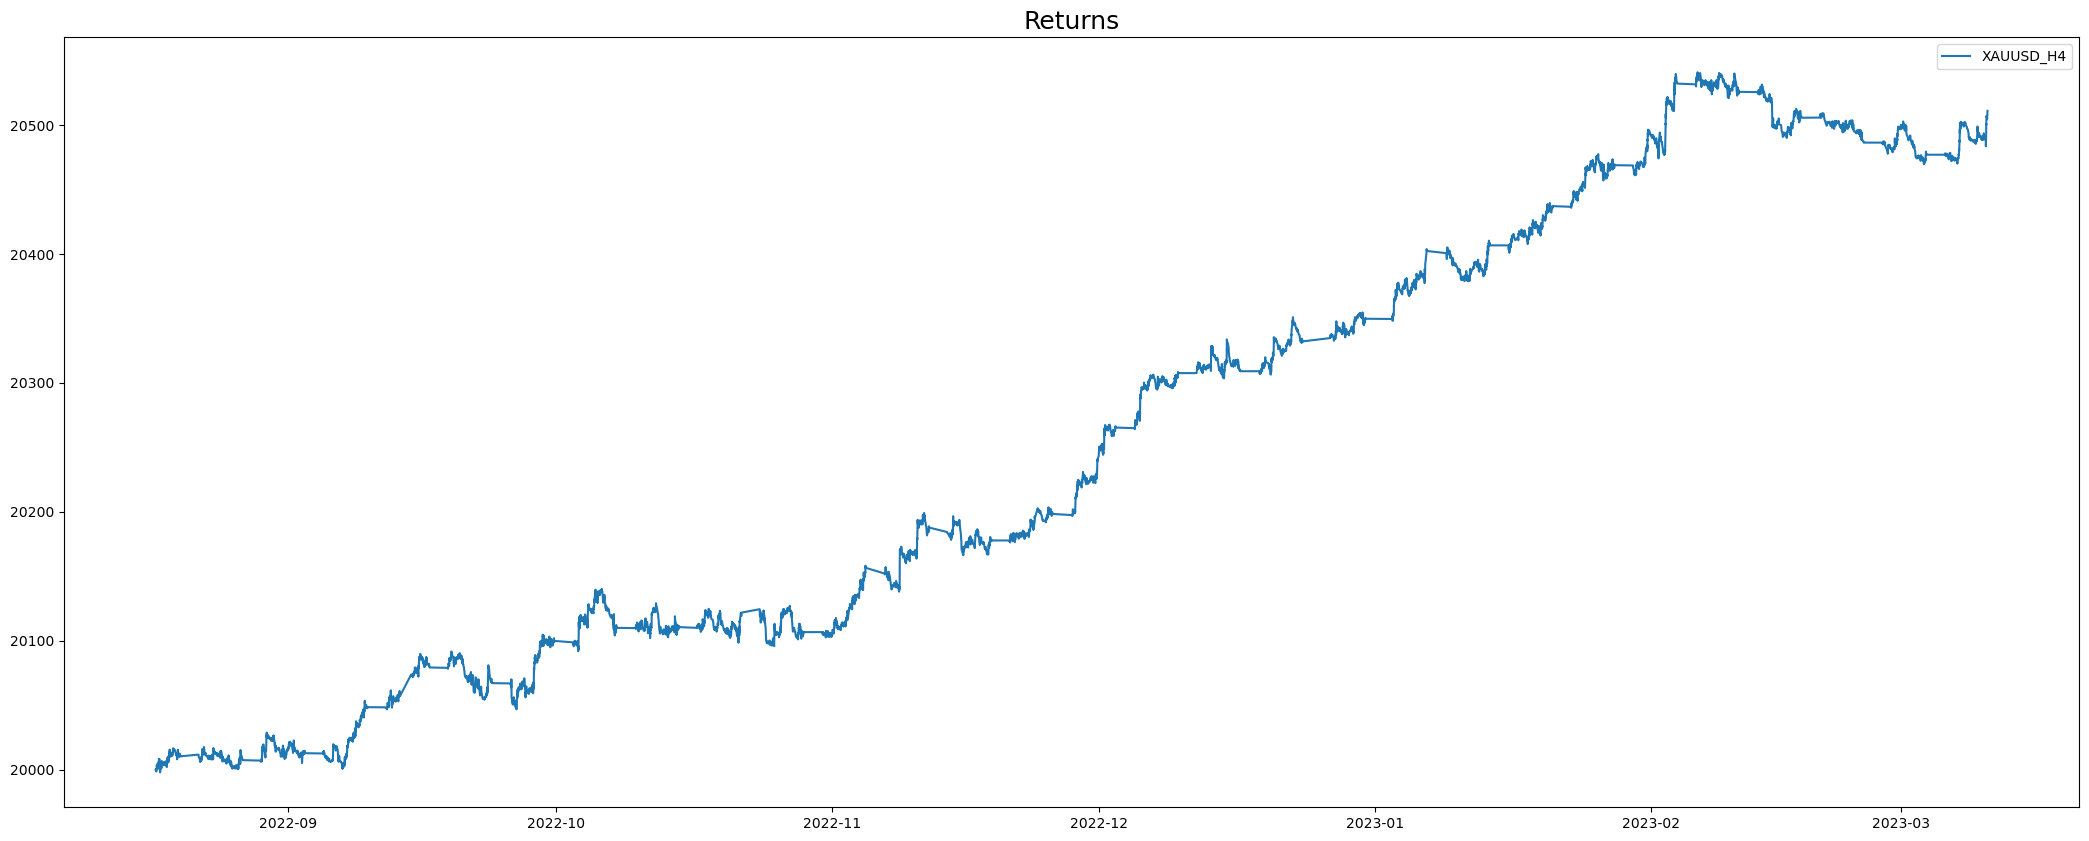

In [14]:
plot_return_trades(result['_trades'],'XAUUSD_H4' , account_size)

In [40]:
bt.plot()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:119: UserWarning: Data contains too many candlesticks to plot; downsampling to '1D'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and w

Row(id='3447', ...)